In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
import os
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = "cuda:0" if torch.cuda.is_available() else "cpu"

## Data Preparation

In [67]:
data = pd.read_csv('../datasets/malicious_urls.csv')
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [68]:
data['type'].value_counts()

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

Since we only want to detect benign or phishing, we clean the dataset to remove all defacement and malware related URLs

In [69]:
data = data[(data['type'] == 'benign') | (data['type'] == 'phishing')] # retain only benign and phishing rows
data['type'] = data['type'].astype('category') # convert benign and phishing to categorical variable

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 522214 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   url     522214 non-null  object  
 1   type    522214 non-null  category
dtypes: category(1), object(1)
memory usage: 8.5+ MB


In [71]:
data['type'].value_counts()

type
benign      428103
phishing     94111
Name: count, dtype: int64

We observe there are significantly more entries with benign labels than phishing. To address the dataset imbalance, we will undersample the benign entries in the dataset.

In [72]:
benign_data = data[data['type'] == 'benign']
phishing_data = data[data['type'] == 'phishing']
undersampled_benign = benign_data.sample(n=len(phishing_data), random_state=1234)
balanced_data = pd.concat([undersampled_benign, phishing_data])

In [73]:
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188222 entries, 439133 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   url     188222 non-null  object  
 1   type    188222 non-null  category
dtypes: category(1), object(1)
memory usage: 3.1+ MB


Now we binarise the categorical data by mapping benign to 0 and phishing to 1

In [74]:
# binarise data
balanced_data['type'] = balanced_data['type'].cat.codes # convert to 0 for benign and 1 for phishing
print(balanced_data['type'].value_counts())

type
0    94111
1    94111
Name: count, dtype: int64


In [75]:
TRAIN_SPLIT_RATIO = 0.8
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['url'], balanced_data['type'], train_size=TRAIN_SPLIT_RATIO, shuffle=True, random_state=1234)

In [76]:
print("Train split ratio:", TRAIN_SPLIT_RATIO)
print("Train size:", len(train_X))
print("Test size:", len(test_X))

Train split ratio: 0.8
Train size: 150577
Test size: 37645


## Model Setup

In [77]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Below we demonstrate how a URL is tokenized using BERT's `subword tokenizer` to allow the model to learn meaningful context-indepedent representations. This subword tokenization algorithm decomposes long strings into meaningful subwords that allows the model to learn meaningful context-dependent representations. This is especially useful in tokenization of URLs as URLs are often single strings and thus, will not work well with word-level tokenizers.

In [78]:
# Demonstration of tokenization of url
example_url = 'br-icloud.com.br'
print("URL input:", example_url)
encoded_url = tokenizer.tokenize(example_url)
print("Tokenized URL:", encoded_url)

URL input: br-icloud.com.br
Tokenized URL: ['br', '-', 'i', '##c', '##lou', '##d', '.', 'com', '.', 'br']


In [79]:
train_encodings = tokenizer(list(train_X), padding=True, truncation=True)
test_encodings = tokenizer(list(test_X), padding=True, truncation=True)

In [80]:
class URLDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


# we create a custom dataset required for training
train_dataset = URLDataset(train_encodings, list(train_Y))
eval_dataset = URLDataset(test_encodings, list(test_Y))

In [2]:
training_args = TrainingArguments(
    output_dir='../BERT_train_results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=0.00005,
    warmup_steps=500,
    logging_steps=10,
    evaluation_strategy='epoch',
)

NameError: name 'TrainingArguments' is not defined

In [82]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ryan/miniconda3/envs/dsai/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [83]:
trainer.train()

Step,Training Loss,Validation Loss


KeyboardInterrupt: 

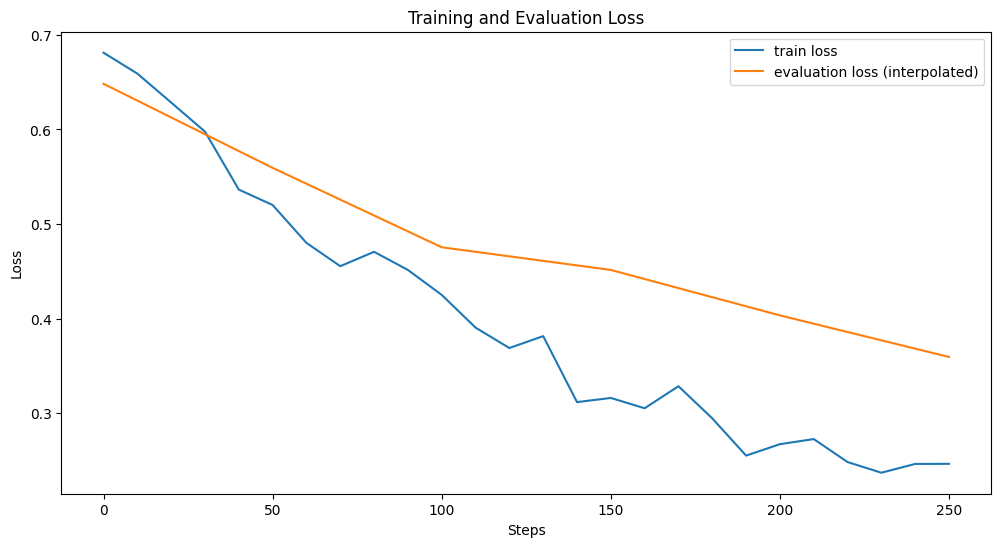

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
# Get the training history
history = trainer.state.log_history

# Plot training and evaluation loss
train_loss = [x['loss'] for x in history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

steps_train = np.arange(len(train_loss)) * 10
steps_eval = np.arange(len(eval_loss)) * 50

# Interpolate eval_loss to have the same number of points as train_loss
interp_eval_loss = np.interp(steps_train, steps_eval, eval_loss)

# Now you can plot train_loss and interp_eval_loss on the same graph
plt.figure(figsize=(12, 6))
plt.plot(steps_train, train_loss, label='train loss')
plt.plot(steps_train, interp_eval_loss, label='evaluation loss (interpolated)')
plt.title('Training and Evaluation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
predictions = trainer.predict(eval_dataset)

In [34]:
pred_Y = np.argmax(predictions.predictions, axis=1)

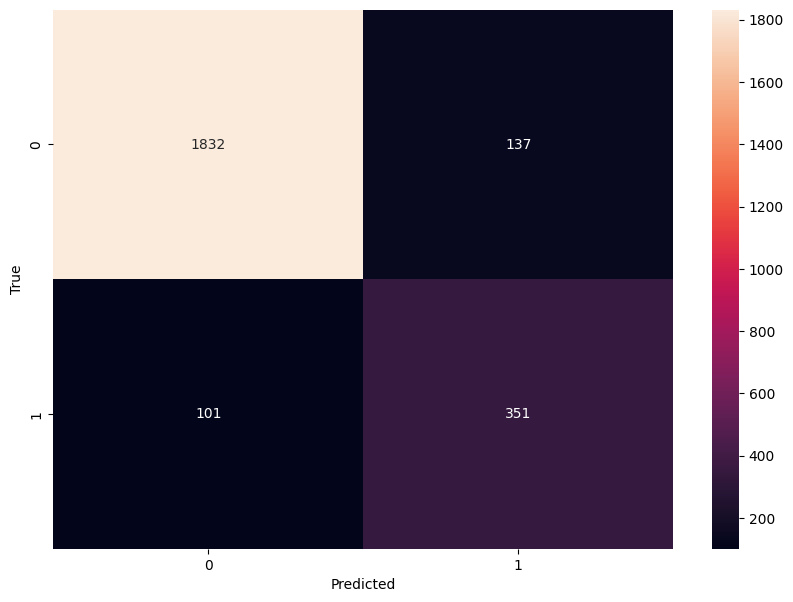

In [35]:
cm = confusion_matrix(test_Y, pred_Y)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [36]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_Y, pred_Y)

print(f'Accuracy: {accuracy}')

Accuracy: 0.9016935150764147
